#Bibliothéque

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, LSTM,Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#load data

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# List files in the dataset directory
folder_path = '/content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data'
print(os.listdir(folder_path))

['F', 'N', 'O', 'Z', 'S']


In [ ]:
# Check if there are subfolders for each class (e.g., Z, O, N, F, S)
for subfolder in ['N', 'O', 'S', 'Z']:
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.exists(subfolder_path):
        print(f"Contents of {subfolder_path}:", os.listdir(subfolder_path))
    else:
        print(f"Subfolder {subfolder} does not exist.")

Contents of /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/N: ['N038.txt', 'N011.txt', 'N005.txt', 'N039.txt', 'N014.txt', 'N006.txt', 'N007.txt', 'N003.txt', 'N012.txt', 'N004.txt', 'N002.txt', 'N016.txt', 'N010.txt', 'N028.txt', 'N017.txt', 'N015.txt', 'N013.txt', 'N071.txt', 'N029.txt', 'N059.txt', 'N001.txt', 'N099.txt', 'N072.txt', 'N065.txt', 'N058.txt', 'N073.txt', 'N067.txt', 'N098.txt', 'N066.txt', 'N064.txt', 'N070.txt', 'N049.txt', 'N060.txt', 'N047.txt', 'N076.txt', 'N075.txt', 'N048.txt', 'N088.txt', 'N089.txt', 'N061.txt', 'N062.txt', 'N100.txt', 'N077.txt', 'N074.txt', 'N063.txt', 'N053.txt', 'N044.txt', 'N086.txt', 'N092.txt', 'N093.txt', 'N087.txt', 'N091.txt', 'N079.txt', 'N090.txt', 'N052.txt', 'N085.txt', 'N046.txt', 'N084.txt', 'N050.txt', 'N078.txt', 'N069.txt', 'N045.txt', 'N083.txt', 'N068.txt', 'N042.txt', 'N041.txt', 'N054.txt', 'N056.txt', 'N082.txt', 'N040.txt', 'N097.txt', 'N096.txt', 'N051.txt', 'N055.txt', 'N019.txt', 'N033.txt', 'N095.txt', 'N0

In [ ]:
def load_class_data(folder_path, class_prefix):
    data = []
    subfolder_path = os.path.join(folder_path, class_prefix)  # Add subfolder
    for i in range(1, 101):
        file_name = f"{class_prefix}{i:03}.txt"  # e.g., Z001.txt, Z002.txt, etc.
        file_path = os.path.join(subfolder_path, file_name)  # File path with subfolder
        print(f"Attempting to load file: {file_path}")  # Debugging line

        if os.path.isfile(file_path):
            try:
                signal = np.loadtxt(file_path)
                data.append(signal)
            except ValueError as e:
                print(f"Error loading {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
    return np.array(data)

In [ ]:
# Load data for each class (update folder paths as per your Kaggle structure)
folder_path = '/content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data'
class_data_F = load_class_data(folder_path, 'F')
class_data_S = load_class_data(folder_path, 'S')

Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F001.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F002.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F003.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F004.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F005.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F006.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F007.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F008.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F009.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/epilepsy_data/F/F010.txt
Attempting to load file: /content/gdrive/MyDrive/Bonn uni data/data/ep

In [ ]:
# Check the shapes of the loaded arrays
print("Shape of class_data_F:", class_data_F.shape)
print("Shape of class_data_S:", class_data_S.shape)

Shape of class_data_F: (100, 4097)
Shape of class_data_S: (100, 4097)


In [ ]:
X_epilepsy_data = np.vstack([class_data for class_data in [class_data_F, class_data_S] if class_data.size > 0])

In [ ]:
print("Shape of concatenated X:", X_epilepsy_data.shape)

Shape of concatenated X: (200, 4097)


In [ ]:
# Define labels for the dataset
y = np.array([0] * len(class_data_F) +
             [1] * len(class_data_S)
             )

In [ ]:
y.shape

(200,)

#data visualisation

In [ ]:
# Function to plot histogram for each class
def plot_histogram(data, class_name, bins=50):
    # Flatten the data to create a histogram of all values across samples
    flattened_data = data.flatten()

    plt.hist(flattened_data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of Class {class_name}')
    plt.xlabel('Signal Value')
    plt.ylabel('Frequency')
    plt.show()

Plotting histograms for each class...


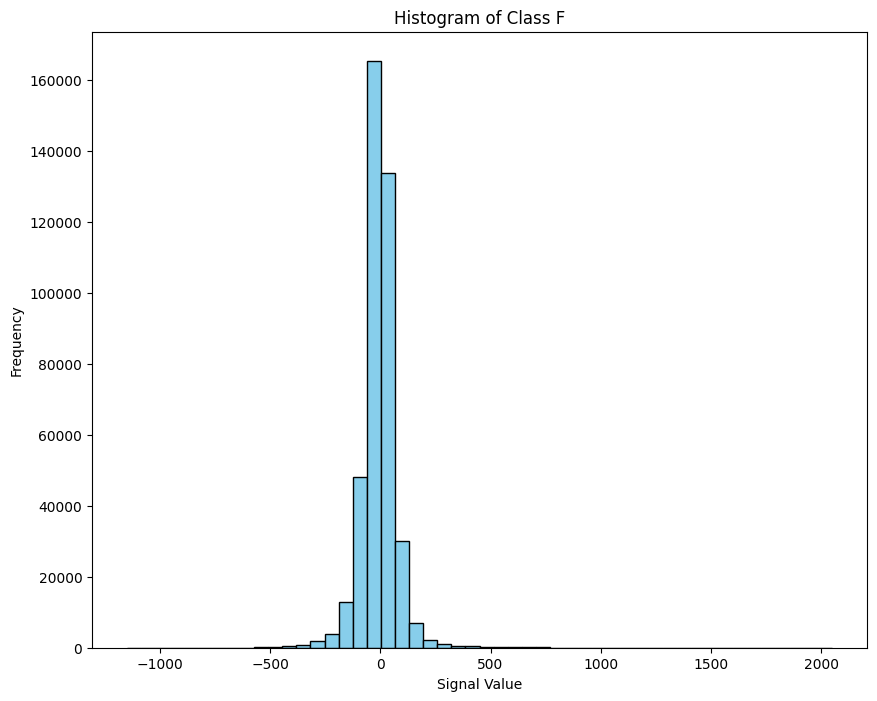

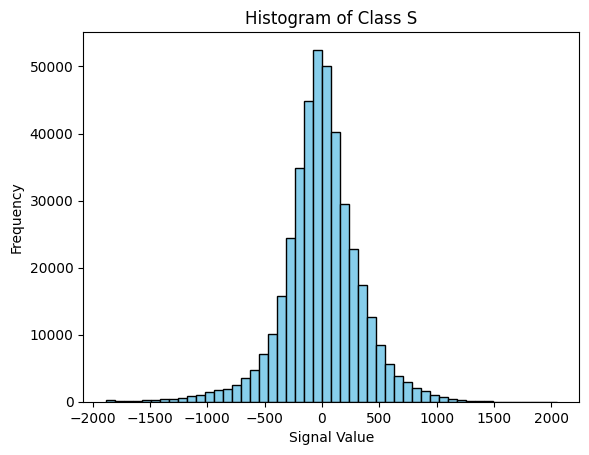

In [ ]:
# Plot histograms for each class
plt.figure(figsize=(10, 8))

print("Plotting histograms for each class...")
plot_histogram(class_data_F, 'F')
plot_histogram(class_data_S, 'S')

In [ ]:
colors = {
    'F': 'blue',
    'S': 'red',

}

In [ ]:
def plot_signal(signal, class_name):
    plt.plot(signal, color=colors[class_name])
    plt.title(f'Sample Signal from Class {class_name}')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Amplitude')
    plt.show()

Plotting sample signals for each class...


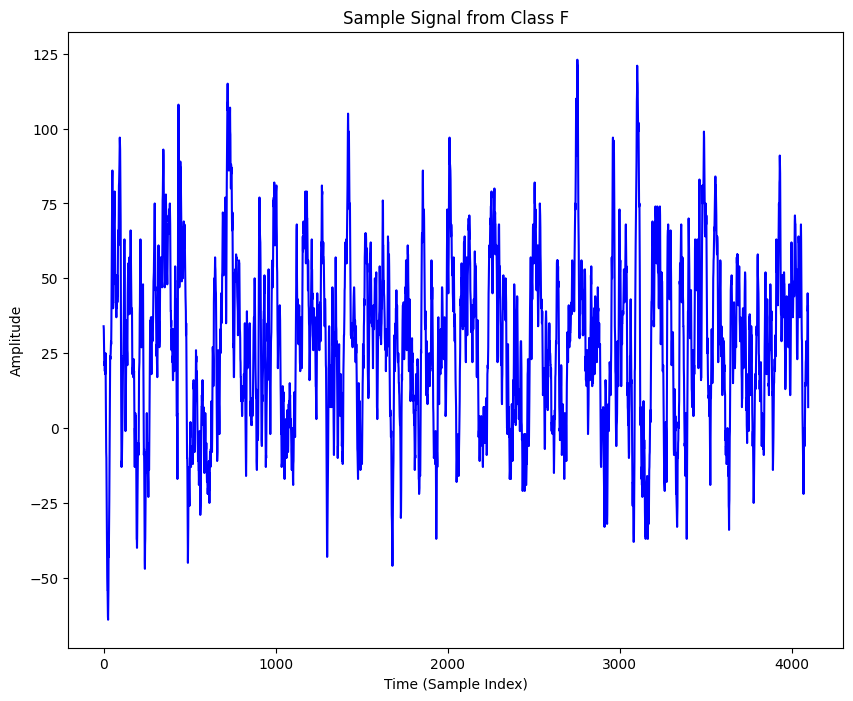

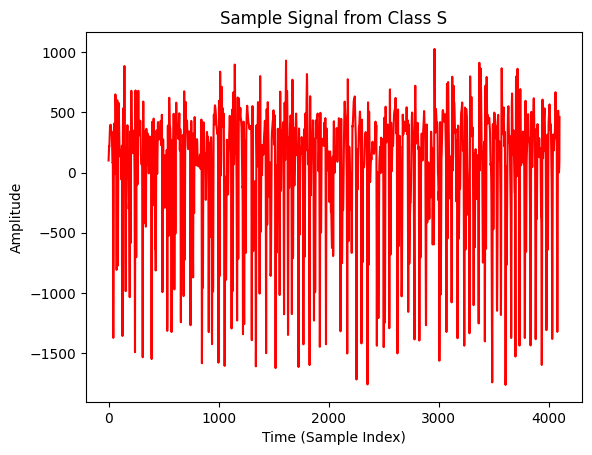

In [ ]:
# Plot one signal from each class (using the first sample as an example)
plt.figure(figsize=(10, 8))

print("Plotting sample signals for each class...")
plot_signal(class_data_F[0], 'F')  # Plot the first signal in class N
plot_signal(class_data_S[0], 'S')  # Plot the first signal in class S

In [ ]:
plt.figure(figsize=(12, 10))
# Define each class and their data in a dictionary for convenience
classes_data = {
    'F': class_data_F[0],  # First sample from Class N
    'S': class_data_S[0],  # First sample from Class S
}

<Figure size 1200x1000 with 0 Axes>

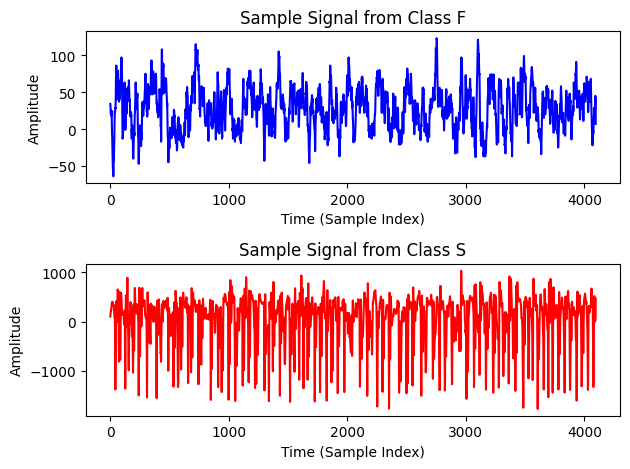

In [ ]:
for i, (class_name, signal) in enumerate(classes_data.items(), 1):
    plt.subplot(2, 1, i)  # Create a subplot for each class (4 rows, 1 column)
    plt.plot(signal, color=colors[class_name])
    plt.title(f'Sample Signal from Class {class_name}')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Amplitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

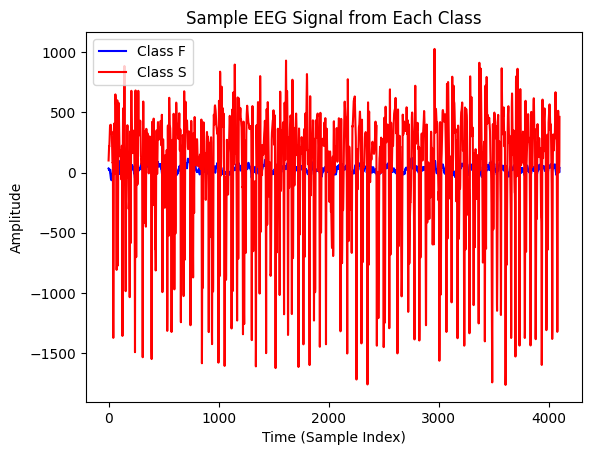

In [ ]:
for class_name, signal in classes_data.items():
    plt.plot(signal, color=colors[class_name], label=f'Class {class_name}')  # Plot each signal with its color and label

# Add title and labels
plt.title('Sample EEG Signal from Each Class')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Amplitude')

# Add legend to distinguish each class
plt.legend()

# Display the plot
plt.show()

#Data normalisation

In [ ]:
scaler = StandardScaler()
X_epilepsy_data_normalized = scaler.fit_transform(X_epilepsy_data)

In [ ]:
X_epilepsy_data_normalized.shape

(200, 4097)

In [ ]:
# Replace `X_epilepsy_data_normalized` with your actual EEG data
X = X_epilepsy_data_normalized  # Shape: (400, 4097)

In [ ]:
X_epilepsy_data_normalized.shape

(200, 4097)

#preprocessing for CWT and CAE

In [ ]:
def segment_signal(signal, window_size=1458, overlap=486):
    step = window_size - overlap
    segments = []
    for start in range(0, len(signal) - window_size + 1, step):
        segments.append(signal[start:start + window_size])
    return np.array(segments)

In [ ]:
window_size = 1458
overlap = 486

In [ ]:
# Apply windowing to all signals
X_windowed = []
y_windowed = []
for signal, label in zip(X, y):
    signal_windows = segment_signal(signal, window_size, overlap)
    X_windowed.extend(signal_windows)
    y_windowed.extend([label] * len(signal_windows))  # Repeat the label for each window

X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)

In [ ]:
print('X_window shape is :', X_windowed.shape)
print('y_window shape is :',y_windowed.shape)

X_window shape is : (600, 1458)
y_window shape is : (600,)


#compute cwt for each signal window

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.7 MB/s eta 0:00:00


In [ ]:
import pywt
from skimage.transform import resize

In [ ]:
def compute_cwt(window, scales=np.arange(1, 128), wavelet='cmor1.5-1.0'):
    coeffs, _ = pywt.cwt(window, scales, wavelet)
    coeffs = np.abs(coeffs)  # Magnitude of coefficients
    resized_coeffs = resize(coeffs, (256, 256), mode='constant')  # Resize to (256, 256)
    return resized_coeffs

In [ ]:
# Apply CWT to all windows
cwt_images = np.array([compute_cwt(window) for window in X_windowed])

In [ ]:
print( 'the shape of cwt_images is :',cwt_images.shape)

the shape of cwt_images is : (600, 256, 256)


In [ ]:
cwt_images = cwt_images[..., np.newaxis]  # Add channel dimension

In [ ]:
print( 'the shape of cwt_images is :',cwt_images.shape)

the shape of cwt_images is : (600, 256, 256, 1)


#CAE

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape

In [ ]:
def build_cae(input_shape=(256, 256, 1)):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(255, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)

    latent_space = Flatten(name='flatten_layer')(x)
    latent_space = Dense(128, activation='relu',name='latent_dense')(latent_space)

    # Decoder
    x = Dense(8 * 8 * 255, activation='relu',name='dec_dense')(latent_space)
    x = Reshape((8, 8, 255), name='dec_reshape')(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    output_layer = Conv2DTranspose(1, (3, 3),strides=(2, 2), activation='sigmoid', padding='same',name='dec_conv5')(x)

    cae = Model(input_layer, output_layer,name='CAE')
    encoder = Model(input_layer, latent_space,name='encoder')
    return cae, encoder

In [ ]:
cae, encoder = build_cae()

In [ ]:
cae.compile(optimizer='adam', loss='mse')

In [ ]:
cae.summary()

Model: "CAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 255)           │         294,015 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 16320)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_dense (Dense)                 │ (None, 128)                 │       2,089,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_dense (Dense)                    │ (None, 16320)               │       2,105,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_reshape (Reshape)                │ (None, 8, 8, 255)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         293,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_conv5 (Conv2DTranspose)          │ (None, 256, 256, 1)         │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,976,448 (18.98 MB)

 Trainable params: 4,976,448 (18.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Normalize the input data
cwt_images = cwt_images / np.max(cwt_images)

In [ ]:
history_cae=cae.fit(cwt_images, cwt_images, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - loss: 0.1948 - val_loss: 0.1590
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.1468 - val_loss: 0.0198
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0096 - val_loss: 0.0198
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0115 - val_loss: 0.0198
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0114 - val_loss: 0.0198
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0108 - val_loss: 0.0198
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0113 - val_loss: 0.0198
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0114 - val_loss: 0.0198
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0100 - val_loss: 0.0198
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0124 - val_loss: 0.0198
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0110 - val_loss: 0.0198
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 

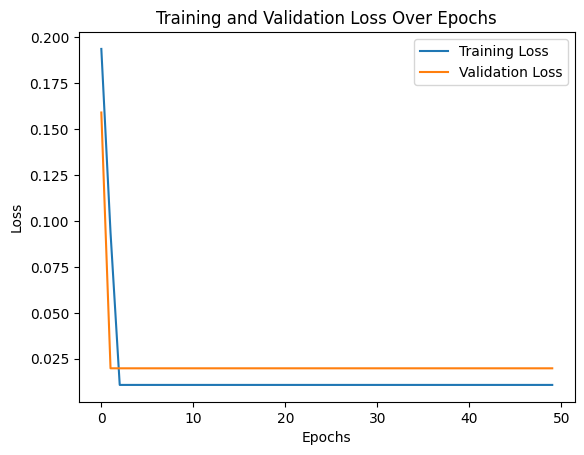

In [ ]:
plt.plot(history_cae.history['loss'], label='Training Loss')
plt.plot(history_cae.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

#PCA

In [ ]:
latent_features = encoder.predict(cwt_images)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
# 4. Apply PCA to latent features
pca = PCA(n_components=128)
latent_features_pca = pca.fit_transform(latent_features)

In [ ]:
latent_features_pca.shape

(600, 128)

In [ ]:
print("Explained variance by 128 components:", sum(pca.explained_variance_ratio_))

Explained variance by 128 components: 1.000000038668096


#stat features extraction

In [ ]:
from scipy.stats import kurtosis, skew

In [ ]:
def compute_stat_features(X):
    mean = np.mean(X, axis=1)
    var = np.var(X, axis=1)
    std = np.std(X, axis=1)
    min_val = np.min(X, axis=1)
    max_val = np.max(X, axis=1)
    range_val = max_val - min_val
    rms = np.sqrt(np.mean(np.square(X), axis=1))
    energy = np.sum(np.square(X), axis=1)
    skewness = np.mean(((X - mean[:, np.newaxis]) / std[:, np.newaxis])**3, axis=1)
    kurtosis = np.mean(((X - mean[:, np.newaxis]) / std[:, np.newaxis])**4, axis=1)
    power = np.mean(np.square(X), axis=1)
    crest_factor = max_val / rms
    shape_factor = rms / mean
    impulse_factor = max_val / mean
    return np.hstack((mean[:, np.newaxis], var[:, np.newaxis], std[:, np.newaxis], min_val[:, np.newaxis],
                     max_val[:, np.newaxis],range_val[:, np.newaxis], rms[:, np.newaxis], energy[:, np.newaxis],
                     skewness[:, np.newaxis], kurtosis[:, np.newaxis], power[:, np.newaxis], crest_factor[:, np.newaxis],
                     shape_factor[:, np.newaxis], impulse_factor[:, np.newaxis]))

In [ ]:
stat_features = compute_stat_features(X_windowed)

In [ ]:
window_ids = np.arange(len(latent_features_pca))

In [ ]:
FAE_with_ids = np.hstack((window_ids[:, np.newaxis], latent_features_pca))
Fstat_with_ids = np.hstack((window_ids[:, np.newaxis], stat_features))

In [ ]:
# Validate IDs before combining
if not np.array_equal(FAE_with_ids[:, 0], Fstat_with_ids[:, 0]):
    raise ValueError("Window IDs do not match between FAE and Fstat!")

In [ ]:
# 6. Combine PCA features with statistical features
hybrid_features = np.hstack((FAE_with_ids, Fstat_with_ids[:, 1:]))

In [ ]:
hybrid_features.shape

(600, 143)

#LSTM classifier

In [ ]:
y_categorical = to_categorical(y_windowed, num_classes=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hybrid_features, y_categorical, test_size=0.3, random_state=42)

In [ ]:
# Build LSTM classifier
lstm_model = Sequential([
    LSTM(128, input_shape=(hybrid_features.shape[1], 1)),
    Dense(2, activation='softmax')
])

In [ ]:
print('Xtrain shape is',X_train.shape)
print('Xtest shape is',X_test.shape)
print('ytrain shape is',y_train.shape)
print('ytest shape is',y_test.shape)

Xtrain shape is (420, 143)
Xtest shape is (180, 143)
ytrain shape is (420, 2)
ytest shape is (180, 2)


In [ ]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
print('xtrain lstm shape is',X_train_lstm.shape)
print('xtest lstm shape is',X_test_lstm.shape)

xtrain lstm shape is (420, 1, 143)
xtest lstm shape is (180, 1, 143)


In [ ]:
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_lstm=lstm_model.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test), epochs=50, batch_size=32)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8052 - loss: 0.4978 - val_accuracy: 0.9056 - val_loss: 0.2779
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9031 - loss: 0.2730 - val_accuracy: 0.9000 - val_loss: 0.2255
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9333 - loss: 0.1961 - val_accuracy: 0.9056 - val_loss: 0.2117
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9391 - loss: 0.1917 - val_accuracy: 0.9222 - val_loss: 0.2055
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9527 - loss: 0.1514 - val_accuracy: 0.9222 - val_loss: 0.1993
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9443 - loss: 0.1446 - val_accuracy: 0.9278 - val_loss: 0.1930
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9614 - loss: 0.1414 - val_accuracy: 0.9222 - val_loss: 0.1796
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9522 - loss: 0.1616 - val_accuracy: 0.9167 - val_loss

In [ ]:
# Step 7: Evaluate the Model
val_accuracy = history_lstm.history['val_accuracy'][-1]
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9555555582046509


In [ ]:
test_loss, test_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9527 - loss: 0.1511 
Test Loss: 0.1229
Test Accuracy: 0.9611


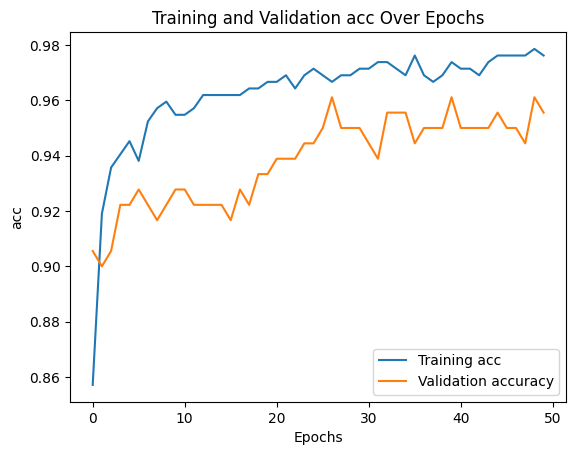

In [ ]:
plt.plot(history_lstm.history['accuracy'], label='Training acc')
plt.plot(history_lstm.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('Training and Validation acc Over Epochs')
plt.legend()
plt.show()

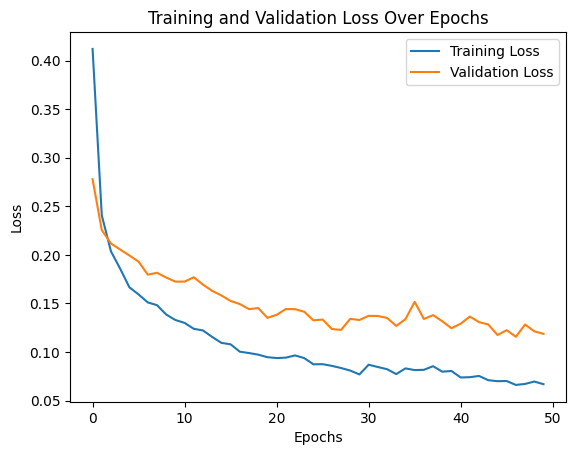

In [ ]:
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = lstm_model.predict(X_test_lstm)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels
y_true = np.argmax(y_test, axis=1)        # True labels

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
cm = confusion_matrix(y_true,y_pred)

<Axes: >

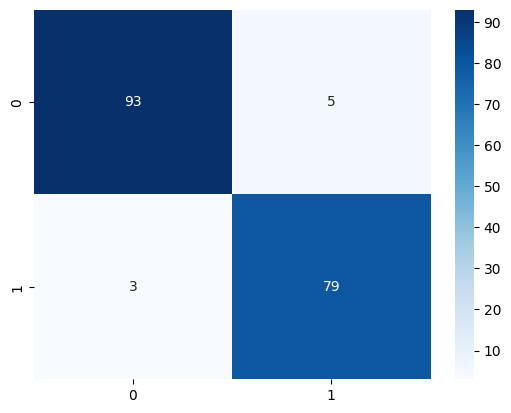

In [ ]:
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")

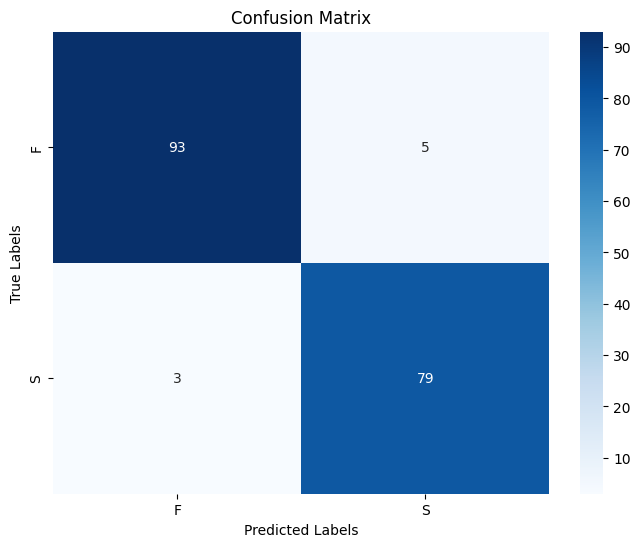

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['F', 'S'], yticklabels=['F', 'S'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Text(0, 0.5, 'Fraction of incorrect predictions')

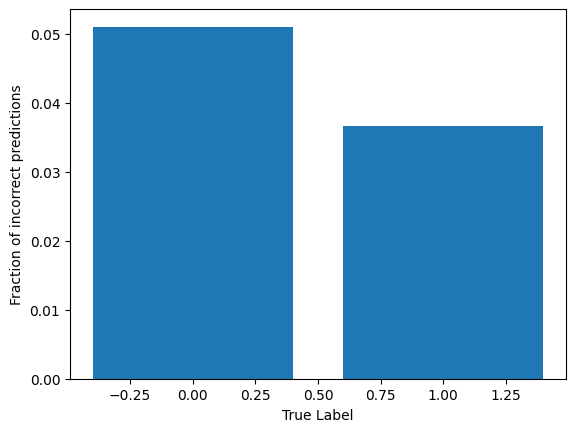

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(2), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [ ]:
from sklearn.metrics import classification_report,roc_auc_score,recall_score,accuracy_score,f1_score

In [ ]:
print(classification_report(y_true, y_pred, target_names=['F', 'S']))

              precision    recall  f1-score   support

           F       0.97      0.95      0.96        98
           S       0.94      0.96      0.95        82

    accuracy                           0.96       180
   macro avg       0.95      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180

